<small><i>This notebook was created by [Alexander Fridman](http://www.rocketscience.ai) for the Lecture Course. Source and license info is on [GitHub](https://github.com/volhahedranovich/jupyter_lectures).</i></small>

# <div class="alert alert-block alert-info">Text Classification with Convolutional and Recurrent Networks</div>

### RNN & LSTM
[Colah's blog. Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

### Packages
1. keras
1. scikit-learn
1. tensorflow (or theano)
1. numpy
1. pandas

### Data

[20 News Groups](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)

In [1]:
import os
import pickle
import random
import shutil
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import SVG
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Embedding, Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


%matplotlib inline

Using TensorFlow backend.


### <div class="alert alert-block alert-success">Prepare a dataset</div>
1. Select N random classes.
1. Save corresponding data (texts and targets) - each class into separate folder.

In [2]:
N_CLASSES = 5
DATASET_PATH = 'data'

In [3]:
assert N_CLASSES < 20

# load dataset
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# select N_CLASSES at random
selected_target_names = set(random.sample(data['target_names'], N_CLASSES))

# found positions of items of selected classes
indexes = [i for i, y_i in enumerate(data['target']) 
           if data['target_names'][y_i] in selected_target_names]
texts = [data['data'][i] for i in indexes]
targets = [data['target_names'][data['target'][i]] for i in indexes]

print('#texts:', len(texts))
print('Selected classes:')
print('\n'.join(map(str, Counter(targets).most_common())))

# save dataset
shutil.rmtree(DATASET_PATH, ignore_errors=True)
os.makedirs(DATASET_PATH, exist_ok=True)

# create separate folder for each class
for target_name in selected_target_names:
    os.makedirs(os.path.join(DATASET_PATH, target_name), exist_ok=True)
    
for i, (target, text) in enumerate(sorted(zip(targets, texts))):
    path = os.path.join(DATASET_PATH, target, r'{}.txt'.format(i))
    
    with open(path, 'w+', encoding='utf8') as f:
        f.write(text)

#texts: 4489
Selected classes:
('comp.windows.x', 988)
('sci.space', 987)
('talk.politics.mideast', 940)
('alt.atheism', 799)
('talk.politics.misc', 775)


### <div class="alert alert-block alert-success">Load dataset</div>

In [4]:
def load_data(path):
    """
    data loading function
    
    assumes there is a folder full of *.txt files for each class
    """
    texts, targets = [], []
    
    for target in os.listdir(path):
        target_path = os.path.join(path, target)
        
        for text_file_name in os.listdir(target_path):
            text_file_path = os.path.join(target_path, text_file_name)
            
            targets.append(target)
            with open(text_file_path, encoding='utf8') as f:
                texts.append(f.read())
                
    return texts, targets

In [5]:
texts, targets = load_data(DATASET_PATH)
N_CLASSES = len(np.unique(targets))

print('Dataset loaded (class counts):')
print('\n'.join(map(str, Counter(targets).most_common())))

Dataset loaded (class counts):
('comp.windows.x', 988)
('sci.space', 987)
('talk.politics.mideast', 940)
('alt.atheism', 799)
('talk.politics.misc', 775)


### <div class="alert alert-block alert-success">Split dataset into train, test, valid</div>

In [6]:
train_texts, test_texts, train_targets, test_targets = train_test_split(texts,
                                                                        targets,
                                                                        test_size=0.2,
                                                                        stratify=targets,
                                                                        random_state=42)
train_texts, valid_texts, train_targets, valid_targets = train_test_split(train_texts,
                                                                          train_targets,
                                                                          test_size=0.2,
                                                                          stratify=train_targets,
                                                                          random_state=42)

### <div class="alert alert-block alert-success">Encode targets</div>

>Also convert targets into 1-hot format required by using categorical_crossentropy loss 

In [7]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_targets)
y_valid = label_encoder.transform(valid_targets)
y_test = label_encoder.transform(test_targets)

y_train_1_hot = to_categorical(y_train, N_CLASSES)
y_valid_1_hot = to_categorical(y_valid, N_CLASSES)

with open('label_encoder.p', 'wb') as f:
    pickle.dump(label_encoder, f)

### <div class="alert alert-block alert-success">Tokenize and encode texts</div>
>Limit number of tokens with NUM_WORDS

*[More info about Tokenizer from keras](https://keras.io/preprocessing/text)*

In [8]:
NUM_WORDS = 20000

tokenizer = Tokenizer(NUM_WORDS)
tokenizer.fit_on_texts(train_texts)
NUM_WORDS = min(NUM_WORDS, len(tokenizer.word_index))
print('Actual NUM_WORDS={}'.format(NUM_WORDS))

with open('tokenizer.p', 'wb') as f:
    pickle.dump(tokenizer, f)

train_texts_encoded = tokenizer.texts_to_sequences(train_texts)
valid_texts_encoded = tokenizer.texts_to_sequences(valid_texts)
test_texts_encoded = tokenizer.texts_to_sequences(test_texts)

Actual NUM_WORDS=20000


### <div class="alert alert-block alert-success">Analyze train text lengths and choose MAX_SEQUENCE_LENGTH</div>

In [9]:
train_text_lengths = list(map(len, train_texts_encoded))
pd.Series(train_text_lengths).describe()

count     2872.000000
mean       250.591922
std        729.802767
min          0.000000
25%         44.000000
50%         95.000000
75%        198.250000
max      10931.000000
dtype: float64

In [10]:
MAX_SEQUENCE_LENGTH = 150

In [11]:
X_train = pad_sequences(train_texts_encoded, MAX_SEQUENCE_LENGTH)
X_valid = pad_sequences(valid_texts_encoded, MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(test_texts_encoded, MAX_SEQUENCE_LENGTH)

### <div class="alert alert-block alert-success">Set up and train a network</div>
Feel free to modify the functions for networks initializing, for example:
1. Initialize an embedding layer with glove weights
2. Add dropout to dense layers or even recurrent connections
3. Try to combine convolutions and recurrent blocks (*[more info](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)*)
    
>Size of the last dense layer is equal to the number of classes

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 100)          2000100   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 2,117,993
Trainable params: 2,117,993
Non-trainable params: 0
_________________________________________________________________
None


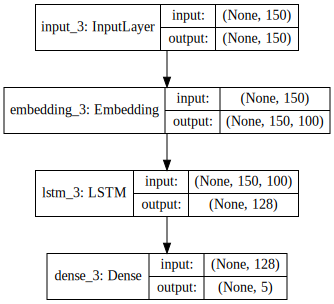

In [14]:
DEFAULT_EMBEDING_DIM = 100


def load_glove_weights_matrix(word_index, embedding_dim=100, glove_dir='glove'):
    weights_matrix = np.zeros((len(word_index) + 1, embedding_dim), dtype=np.float32)
    glove_path = os.path.join(glove_dir, 'glove.twitter.27B.{}d.txt'.format(embedding_dim))
    
    n_words_found = 0
    with open(glove_path) as f:
        for line in f:
            word, *weights = line.strip().split()
            
            if word in word_index:
                weights_matrix[word_index[word]] = np.array(list(map(float, weights)))
                n_words_found += 1
                
    print('{} words found in glove'.format(n_words_found))
    return weights_matrix


def extract_word_index_from_tokenizer(tokenizer):
    return {w: i for w, i in tokenizer.word_index.items() if i <= tokenizer.num_words}

    
def build_cnn_model_with_glove_embeddings(embedding_weights=None):
    if embedding_weights is not None:
        embedding_dim = embedding_weights.shape[1]

        embedding_layer = Embedding(
            NUM_WORDS + 1,
            embedding_dim,
            weights=[embedding_weights],
            input_length=MAX_SEQUENCE_LENGTH, 
            trainable=False)
    else:
        embedding_layer = Embedding(
            NUM_WORDS + 1,
            DEFAULT_EMBEDING_DIM,
            input_length=MAX_SEQUENCE_LENGTH)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(N_CLASSES, activation='softmax')(x)

    return Model(sequence_input, preds)


def build_rnn_model(embedding_weights=None, rnn_size=128):
    if embedding_weights is not None:
        embedding_dim = embedding_weights.shape[1]

        embedding_layer = Embedding(
            NUM_WORDS + 1,
            embedding_dim,
            weights=[embedding_weights],
            input_length=MAX_SEQUENCE_LENGTH, 
            mask_zero=True,
            trainable=False)
    else:
        embedding_layer = Embedding(
            NUM_WORDS + 1,
            DEFAULT_EMBEDING_DIM,
            mask_zero=True,
            input_length=MAX_SEQUENCE_LENGTH)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = LSTM(rnn_size)(embedded_sequences)
    preds = Dense(N_CLASSES, activation='softmax')(x)

    return Model(sequence_input, preds)
    
    
word_index = extract_word_index_from_tokenizer(tokenizer)
# embedding_weights = load_glove_weights_matrix(word_index)
embedding_weights = None
model = build_rnn_model(embedding_weights)

model.compile('adam', 'categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Important
>To save a model we will use `ModelCheckpoint` which saves the model after each epoch (by default).

>Also a model can be saved directly by calling `save` method on the model instance.
    
```python
    model.save('model.hdf5')
```

In [15]:
# prepare directory for checkpoints
shutil.rmtree('checkpoints', ignore_errors=True)
os.makedirs('checkpoints', exist_ok=True)


checkpointer = ModelCheckpoint('checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5')
stopper = EarlyStopping(patience=3)

history = model.fit(X_train, y_train_1_hot,
                    batch_size=32,
                    validation_data=[X_valid, y_valid_1_hot],
                    callbacks=[checkpointer, stopper],
                    epochs=10)

Train on 2872 samples, validate on 719 samples
Epoch 1/10
2872/2872 [==============================] - 13s 4ms/step - loss: 1.4884 - categorical_accuracy: 0.3712 - val_loss: 1.1764 - val_categorical_accuracy: 0.5257
Epoch 2/10
2872/2872 [==============================] - 12s 4ms/step - loss: 0.9784 - categorical_accuracy: 0.6542 - val_loss: 0.9375 - val_categorical_accuracy: 0.6064
Epoch 3/10
2872/2872 [==============================] - 12s 4ms/step - loss: 0.4898 - categorical_accuracy: 0.8353 - val_loss: 0.7264 - val_categorical_accuracy: 0.7065
Epoch 4/10
2872/2872 [==============================] - 12s 4ms/step - loss: 0.2181 - categorical_accuracy: 0.9300 - val_loss: 0.7972 - val_categorical_accuracy: 0.7121
Epoch 5/10
2872/2872 [==============================] - 12s 4ms/step - loss: 0.1340 - categorical_accuracy: 0.9593 - val_loss: 0.8632 - val_categorical_accuracy: 0.6718
Epoch 6/10
2872/2872 [==============================] - 12s 4ms/step - loss: 0.0883 - categorical_accuracy: 

### <div class="alert alert-block alert-success">Visualize learning curves and select the best checkpoint</div>

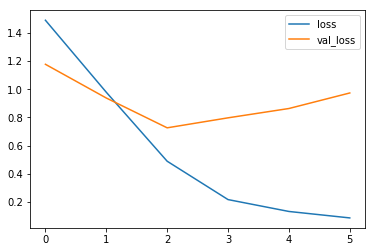

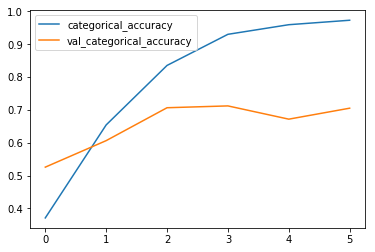

In [16]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot();

>From the learning curves plotted above we can conclude that our model reaches the best performance after the $i^{th}$ epoch and then would be overfitted.

### <div class="alert alert-block alert-success">Load $i^{th}$ checkpoint and measure quality on the test set</div>

In [27]:
model = load_model('checkpoints/weights.02-0.70.hdf5')

In [28]:
y_test_pred_proba = model.predict(X_test, batch_size=256, verbose=1)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

976/976 [==============================] - 4s 4ms/step


In [29]:
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

 comp.os.ms-windows.misc       0.56      0.66      0.61       197
comp.sys.ibm.pc.hardware       0.62      0.49      0.55       197
            misc.forsale       0.87      0.77      0.82       195
      rec.sport.baseball       0.61      0.86      0.72       199
   talk.politics.mideast       0.89      0.62      0.73       188

             avg / total       0.71      0.68      0.68       976



### <div class="alert alert-block alert-success">Load model and run inference on "new" data</div>

In [30]:
# load pipeline (only tokenzer in this case)
with open('tokenizer.p', 'rb') as f:
    tokenizer = pickle.load(f)
    
# load label encoder (required to restore targets from model predictions)
with open('label_encoder.p', 'rb') as f:
    label_encoder = pickle.load(f)
    
# load the model
model = model = load_model('checkpoints/weights.02-0.70.hdf5')
    
# let's imagine that "new" data is a set of *.txt files in NEW_DATA_PATH dir
NEW_DATA_PATH = 'data/misc.forsale'
new_texts = [open(os.path.join(NEW_DATA_PATH, file_name)).read() 
             for file_name in os.listdir(NEW_DATA_PATH)]

new_texts_encoded = tokenizer.texts_to_sequences(new_texts)
X_new = pad_sequences(new_texts_encoded, MAX_SEQUENCE_LENGTH)

# run prediction on "new" data (we will get a vector of class probabilities for each text)
y_new_pred_proba = model.predict(X_new, batch_size=256, verbose=1)
# select most probable class for each text
y_new_pred = np.argmax(y_new_pred_proba, axis=1)
# restore target names
y_new_targets = label_encoder.inverse_transform(y_new_pred)

975/975 [==============================] - 4s 4ms/step


/home/volha/py34/lib/python3.4/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [31]:
Counter(y_new_targets)

Counter({'comp.os.ms-windows.misc': 17,
         'comp.sys.ibm.pc.hardware': 40,
         'misc.forsale': 868,
         'rec.sport.baseball': 45,
         'talk.politics.mideast': 5})

### <div class="alert alert-block alert-success">Run inference on a string of some text</div>

In [32]:
def predict_on_text(model, label_encoder, tokenizer, text, n_top_labels):
    text = [text]
    text_encoded = tokenizer.texts_to_sequences(text)
    X = pad_sequences(text_encoded, MAX_SEQUENCE_LENGTH)
    y_pred_proba = model.predict(X)[0]
    
    top_n_label_idxs = y_pred_proba.argsort()[::-1][:n_top_labels]
    top_n_probs = y_pred_proba[top_n_label_idxs]
    top_n_labels = label_encoder.inverse_transform(top_n_label_idxs)
    
    return list(zip(top_n_labels, top_n_probs))

In [33]:
text = "hardware pc processor and a bit of deep space"
n_labels = 3

predict_on_text(model, label_encoder, tokenizer, text, n_labels)

/home/volha/py34/lib/python3.4/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[('comp.sys.ibm.pc.hardware', 0.53675175),
 ('comp.os.ms-windows.misc', 0.37999728),
 ('misc.forsale', 0.052131794)]